# Vision Investment Rental Worthiness Predictor.

In [1]:
import numpy as np
import sklearn 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import cross_val_score
%matplotlib inline

C:\Users\Rakshith\Miniconda3\envs\machinelearning\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
train1 = pd.read_excel("datasets/dataset1.xlsx")
train2 = pd.read_excel("datasets/dataset2.xlsx")

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/dataset1.xlsx'

In [3]:
train1.columns

Index(['Row Number', 'Fico Score', 'Length of Employment (Months)',
       'Length of Current Residency  (Months)', 'Monthly Income',
       'Debt to Income percentage', 'Outcome'],
      dtype='object')

In [4]:
train2.columns

Index(['Row Number', 'Fico Score', 'Length of Employment (Months)',
       'Length of Current Residency  (Months)', 'Monthly Income',
       'Debt to Income percentage', 'Outcome'],
      dtype='object')

In [5]:
train2 = train2.drop(['Row Number'],axis=1)
train1 = train1.drop(['Row Number'],axis=1)

In [6]:
train = pd.concat([train1,train2]).reset_index()
train.head()

,index,Fico Score,Length of Employment (Months),Length of Current Residency (Months),Monthly Income,Debt to Income percentage,Outcome
0,0,593,56,7,7920,50.313829,1
1,1,744,34,11,8748,24.693483,1
2,2,845,57,29,5582,79.617316,0
3,3,624,23,21,2418,81.520067,0
4,4,832,35,5,6637,85.491807,0


In [7]:
# percentage of 0s and 1s
(train.Outcome.value_counts()/750)*100

1    59.2
0    40.8
Name: Outcome, dtype: float64

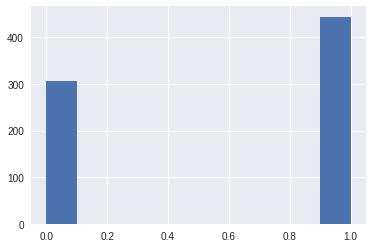

In [8]:
train.Outcome.loc[:,].hist()

In [9]:
train.isnull().sum()

index                                    0
Fico Score                               0
Length of Employment (Months)            0
Length of Current Residency  (Months)    0
Monthly Income                           0
Debt to Income percentage                0
Outcome                                  0
dtype: int64

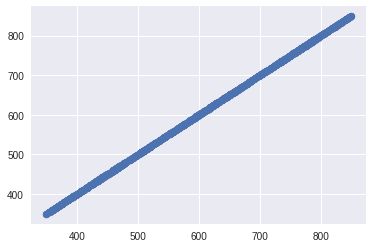

In [10]:
plt.scatter(x=train.iloc[:,1:2],y=train.iloc[:,1:2])

In [11]:
# prepare values to be considered by the model.
# X includes all the features Fico Score	Length of Employment (Months)	Length of Current Residency (Months)	Monthly Income	Debt to Income percentage	
X = train.iloc[:,1:-1].values

In [12]:
X

array([[  5.93000000e+02,   5.60000000e+01,   7.00000000e+00,
          7.92000000e+03,   5.03138288e+01],
       [  7.44000000e+02,   3.40000000e+01,   1.10000000e+01,
          8.74800000e+03,   2.46934827e+01],
       [  8.45000000e+02,   5.70000000e+01,   2.90000000e+01,
          5.58200000e+03,   7.96173161e+01],
       ..., 
       [  7.55000000e+02,   4.80000000e+01,   9.00000000e+00,
          4.07600000e+03,   2.32497474e+01],
       [  4.26000000e+02,   5.70000000e+01,   8.00000000e+00,
          4.66300000e+03,   6.43538894e+00],
       [  6.62000000e+02,   1.90000000e+01,   5.00000000e+00,
          9.88400000e+03,   7.62563945e+01]])

In [13]:
# Response labels
y = train.iloc[:,6:].values

In [14]:
y

array([[1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
    

In [15]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [16]:
X_test

array([[  4.18000000e+02,   4.10000000e+01,   2.20000000e+01,
          4.16000000e+03,   3.65607540e+00],
       [  6.76000000e+02,   7.00000000e+00,   1.60000000e+01,
          2.59600000e+03,   4.69451188e+01],
       [  6.57000000e+02,   5.70000000e+01,   1.40000000e+01,
          3.82000000e+03,   2.19586142e+01],
       ..., 
       [  4.54000000e+02,   1.20000000e+01,   3.50000000e+01,
          8.68400000e+03,   6.04331864e+00],
       [  7.68000000e+02,   6.00000000e+00,   1.40000000e+01,
          2.81800000e+03,   2.08128292e+01],
       [  7.21000000e+02,   5.60000000e+01,   3.30000000e+01,
          5.33500000e+03,   3.62312038e+01]])

In [17]:
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
X_train = sc_x.fit_transform(X_train)
X_test = sc_x.transform(X_test)

In [18]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier(n_estimators=5,learning_rate=0.02)

In [19]:
y_train[0]

array([0])

In [20]:
model_xgb.fit(X_train,y_train.ravel())

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.02, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=5, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [21]:
predictions = model_xgb.predict(X_test)

In [22]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,predictions)

0.7661290322580645

In [23]:
from sklearn.ensemble import RandomForestClassifier
model_rf = RandomForestClassifier(n_estimators=1000)
model_rf.fit(X_train,y_train.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [24]:
predictions_rf = model_rf.predict(X_test)

In [25]:
accuracy_score(y_test,predictions_rf)

0.74596774193548387

In [26]:
from sklearn.linear_model import LassoCV
model_lasso = LassoCV(eps=0.0001, n_alphas=1000)
model_lasso.fit(X_train,y_train.ravel())

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.0001, fit_intercept=True,
    max_iter=1000, n_alphas=1000, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [27]:
predictions_lasso = model_lasso.predict(X_test)
predictions_lasso = predictions_lasso>0.5

In [28]:
accuracy_score(y_test,predictions_lasso)

0.79032258064516125

In [29]:
from sklearn.linear_model import ElasticNet
model_enet = ElasticNet()
model_enet.fit(X_train,y_train.ravel())

ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [30]:
predictions_enet = model_enet.predict(X_test)
predictions_enet = predictions_enet>0.5

In [31]:
accuracy_score(y_test,predictions_enet)

0.6088709677419355

In [32]:
from sklearn.linear_model import LogisticRegression
model_logregression = LogisticRegression()
model_logregression.fit(X_train,y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [33]:
predictions_logregression = model_logregression.predict(X_test)
predictions_logregression

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1])

In [34]:
accuracy_score(y_test,predictions_logregression)

0.79435483870967738

In [35]:
from sklearn.svm import SVC
model_svc = SVC(C=1,kernel='rbf')
model_svc.fit(X_train,y_train.ravel())

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [36]:
predictions_svc = model_svc.predict(X_test)
predictions_svc

array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1])

In [37]:
accuracy_score(y_test,predictions_svc)

0.78629032258064513

In [38]:
model_lgb = lgb.LGBMClassifier(num_leaves=122,learning_rate=0.0001)
model_lgb.fit(X_train,y_train.ravel())

LGBMClassifier(boosting_type='gbdt', colsample_bytree=1, learning_rate=0.0001,
        max_bin=255, max_depth=-1, min_child_samples=10,
        min_child_weight=5, min_split_gain=0, n_estimators=10, nthread=-1,
        num_leaves=122, objective='binary', reg_alpha=0, reg_lambda=0,
        seed=0, silent=True, subsample=1, subsample_for_bin=50000,
        subsample_freq=1)

In [39]:
predictions_lgb = model_lgb.predict(X_test)
predictions_lgb

array([1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1])

In [40]:
accuracy_score(y_test,predictions_lgb)

0.77016129032258063

In [45]:
#Validation function
n_folds = 5

def cross_score(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    return cross_val_score(model, X, y.ravel(), scoring="accuracy", cv = kf)    

In [46]:
def model_performance(model):
    scores = cross_score(model)
    print(scores)
    print("\n")
    print("Mean:{}, Standard Deviation:{}".format(np.mean(scores),np.std(scores)))

In [47]:
# How does logistic ression stay along for predictions?
model_performance(model_logregression)

[ 0.64238411  0.62666667  0.85333333  0.81333333  0.81879195]


Mean:0.7509018771204646, Standard Deviation:0.09613474461942664


In [48]:
# How does xgboost stay along for predictions?
model_performance(model_xgb)

[ 0.60927152  0.64666667  0.82666667  0.78        0.80536913]


Mean:0.7335947968057839, Standard Deviation:0.08829512621512021


In [49]:
# How does SVC stay along for predictions?
model_performance(model_svc)

[ 0.58940397  0.59333333  0.59333333  0.59333333  0.59060403]


Mean:0.5920016000711142, Standard Deviation:0.001674599362057791


In [50]:
# How does lgb stay along for predictions?# How does xgboost stay along for predictions?
model_performance(model_lgb)

[ 0.60264901  0.62666667  0.79333333  0.70666667  0.81879195]


Mean:0.7096215239195816, Standard Deviation:0.08632404895515006
